In [2]:
# Raster I/O and math
import rasterio
from rasterio.warp import calculate_default_transform
from rasterstats import zonal_stats

# Image processing
import numpy as np
from skimage import exposure
import cv2

# Blob detection
from math import sqrt
from skimage.feature import blob_log

# Others
import pandas as pd
import matplotlib.pyplot as plt
from osmnx import gdf_from_place
from geopy.geocoders import Nominatim
from tqdm import tqdm

%matplotlib inline

# Read in the Gridded Population and Black Marble rasters

In [2]:
GPW_PATH = 'input/Resampled_BlackMarble_GPW/gpw_v4_population_count_20151.tif'
BM_PATH = 'input/Resampled_BlackMarble_GPW/BlackMarble_mosaic_resample_32BIT_normalize.tif'

In [3]:
with rasterio.open(GPW_PATH) as src:
    
    # The profile contains the metadata
    GPW_profile = src.profile
    
    # Read the first and only band into an array
    GPW = src.read(1)

In [4]:
with rasterio.open(BM_PATH) as src:
    
    # The profile contains the metadata
    BM_profile = src.profile
    
    # Read the first and only band into an array
    BM = src.read(1)

# Image processing

### Replace huge negative `nodata` values with zeros

In [5]:
GPW[ GPW < -10000000000 ] = 0
BM[ BM < -10000000000 ] = 0

### Remove the concept of `nodata`

In [6]:
del GPW_profile['nodata']
del BM_profile['nodata']

### Normalization by Scaling Between 0 and 1

In [7]:
def min_max_scaler(A):
    results = (A - A.min()) / (A.max() - A.min())
    return results

GPW_scaled = min_max_scaler(GPW)
BM_scaled = min_max_scaler(BM)

### Smooth images with Gaussian Blur

Make GPW kernel a bit bigger to compensate for the fact that Black Marble is already somewhat blurred.

In [8]:
GPW_kernel_size = (15,15)
GPW_gaussian = cv2.GaussianBlur(GPW_scaled,GPW_kernel_size,0)

In [9]:
BM_kernel_size = (11,11)
BM_gaussian = cv2.GaussianBlur(BM_scaled,BM_kernel_size,0)

### Contrast Stretching

http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html

In [10]:
def contrast_stretch(img, pmin, pmax):
    pmin, pmax = np.percentile(img, (pmin, pmax))
    img_rescale = exposure.rescale_intensity(img, in_range=(pmin, pmax))
    return img_rescale

Give GPW a little more contrast enhancement because Black Marble is already brighter.

In [11]:
GPW_gaussian_enhanced = contrast_stretch(GPW_gaussian, 0.75, 99.25)

In [12]:
BM_gaussian_enhanced = contrast_stretch(BM_gaussian, 0.075, 99.925)

### Save to GeoTIFF

In [13]:
with rasterio.open('output/GPW_smoothed.tif', 'w', **GPW_profile) as dst:
    dst.write(GPW_gaussian_enhanced, 1)

/anaconda/lib/python2.7/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


In [14]:
with rasterio.open('output/BM_smoothed.tif', 'w', **BM_profile) as dst:
    dst.write(BM_gaussian_enhanced, 1)

# Calculate difference between the rasters

First we calculate Gridded Population of the World minus Black Marble.

In [15]:
GPW_minus_BM_smoothed = GPW_gaussian_enhanced - BM_gaussian_enhanced

Delete the gaussian enhanced layers from memory.

In [16]:
del GPW_gaussian_enhanced
del BM_gaussian_enhanced

Save smoothed difference to geotiff.

In [17]:
GPW_minus_BM_profile = GPW_profile

with rasterio.open('output/GPW_minus_BM_smoothed.tif', 'w', **GPW_minus_BM_profile) as dst:
    dst.write(GPW_minus_BM_smoothed, 1)

We also calculate Black Marble minus Gridded Population of the World (it will be handy to have this as a separate array for blob detection).

In [18]:
BM_minus_GPW_smoothed = -1 * GPW_minus_BM_smoothed

Also save the unsmoothed difference to geotiff.

In [19]:
GPW_minus_BM = GPW_scaled - BM_scaled

In [20]:
with rasterio.open('output/GPW_minus_BM_raw.tif', 'w', **GPW_minus_BM_profile) as dst:
    dst.write(GPW_minus_BM, 1)

Delete unsmoothed arrays from memory

In [21]:
del GPW_minus_BM
del GPW_scaled
del BM_scaled

# More people than lights in smoothed difference

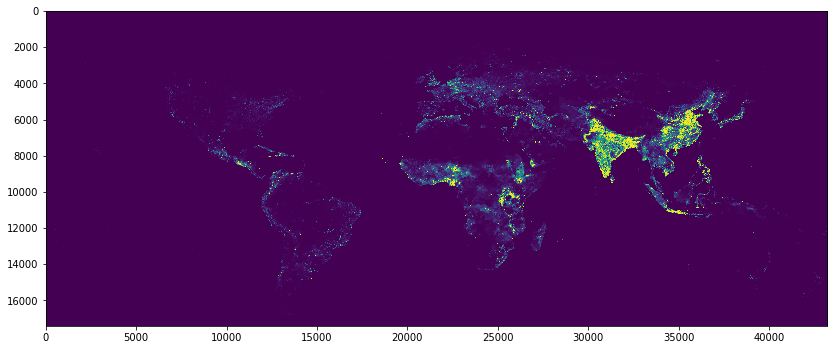

In [22]:
GPW_minus_BM_gte_0 = GPW_minus_BM_smoothed.copy()
np.place(GPW_minus_BM_gte_0, GPW_minus_BM_gte_0<0, 0)
plt.figure(figsize=(14,8))
plt.imshow(GPW_minus_BM_gte_0, cmap="viridis", interpolation='nearest')
plt.show()

Save to geotiff.

In [6]:
GPW_minus_BM_path = 'output/GPW_minus_BM_gte_0.tif'

In [23]:
with rasterio.open(GPW_minus_BM_path, 'w', **GPW_profile) as dst:
    dst.write(GPW_minus_BM_gte_0, 1)

In [24]:
del GPW_minus_BM_gte_0

# More lights than people (smoothed)

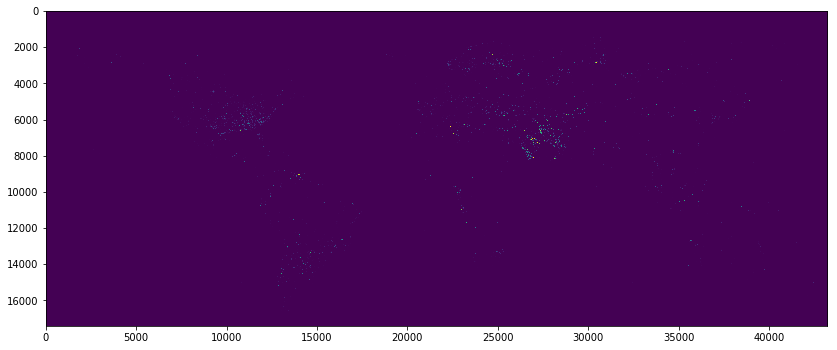

In [25]:
BM_minus_GPW_gte_0 = BM_minus_GPW_smoothed.copy()
np.place(BM_minus_GPW_gte_0, BM_minus_GPW_gte_0<0, 0)
plt.figure(figsize=(14,8))
plt.imshow(BM_minus_GPW_gte_0, cmap="viridis", interpolation='nearest')
plt.show()

Save to geotiff.

In [5]:
BM_minus_GPW_path = 'output/BM_minus_GPW_gte_0.tif'

In [26]:
with rasterio.open(BM_minus_GPW_path, 'w', **GPW_profile) as dst:
    dst.write(BM_minus_GPW_gte_0, 1)

In [27]:
del BM_minus_GPW_gte_0

Delete all of the big image arrays to save memory. They are no longer needed 

In [28]:
del BM
del BM_gaussian
del BM_minus_GPW_smoothed
del GPW
del GPW_gaussian
del GPW_minus_BM_smoothed

# Blob Detection by Place Name

First, search for a place name using OpenStreetMap:

In [3]:
place_name = "Democratic Republic of Congo"

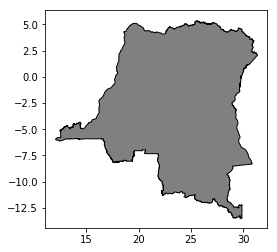

In [4]:
polygon = gdf_from_place(place_name)
polygon.plot(color='gray', edgecolor='black');

In [7]:
GPW_minus_BM_stats = zonal_stats(
                        polygon,
                        GPW_minus_BM_path,
                        all_touched=True,
                        add_stats={'maxcell': lambda x: np.unravel_index(x.argmax(), x.shape)},
                        raster_out=True
                    )[0]

/anaconda/lib/python2.7/site-packages/rasterstats/main.py:142: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
/anaconda/lib/python2.7/site-packages/rasterstats/io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)
/anaconda/lib/python2.7/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


Places with more people than lights.

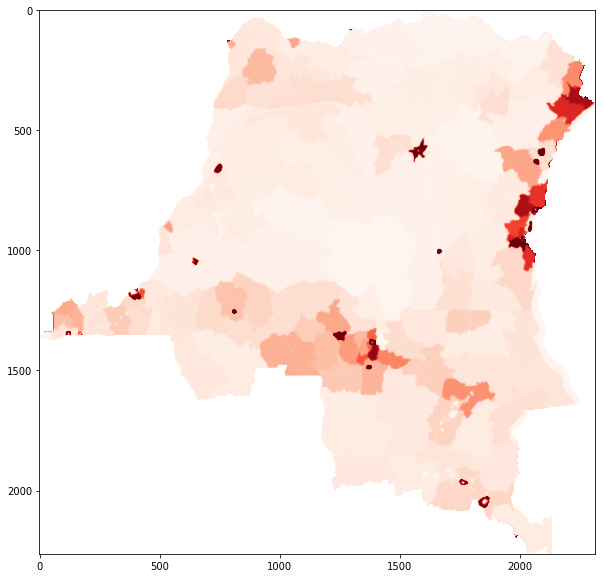

In [8]:
plt.figure(figsize = (10,10))
plt.imshow(GPW_minus_BM_stats['mini_raster_array'], cmap='Reds', interpolation='nearest')
plt.show()

In [9]:
BM_minus_GPW_stats = zonal_stats(
                        polygon,
                        BM_minus_GPW_path,
                        all_touched=True,
                        add_stats={'maxcell': lambda x: np.unravel_index(x.argmax(), x.shape)},
                        raster_out=True
                    )[0]

Places with more lights than people.

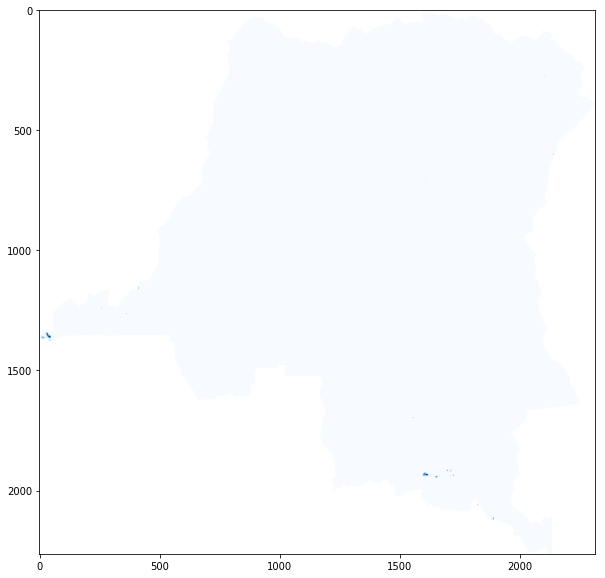

In [10]:
plt.figure(figsize = (10,10))
plt.imshow(BM_minus_GPW_stats['mini_raster_array'], cmap='Blues', interpolation='nearest')
plt.show()

In [11]:
def pixel2coord(transform, row, col):
    ''' converts row col to lat, lon'''
    coff, roff = (0.5, 0.5)
    x, y = transform * transform.translation(coff, roff) * (col, row)
    return y, x

The pixel with the most people, least lights:

In [12]:
pixel2coord(GPW_minus_BM_stats['mini_raster_affine'], *GPW_minus_BM_stats['maxcell'])

(4.7375000000086418, 22.870833333334712)

The pixel with the most lights, least people:

In [13]:
pixel2coord(BM_minus_GPW_stats['mini_raster_affine'], *BM_minus_GPW_stats['maxcell'])

(-5.929166666658098, 12.395833333334641)

In [14]:
def detect_blobs(array, color, cmap=None, threshold=0.5):
    
    array.mask = False
    
    blobs = blob_log(array, max_sigma=30, num_sigma=10, threshold=threshold)
    # Compute blob radius in the 3rd column.
    blobs[:, 2] = blobs[:, 2] * sqrt(2)
    
    title = 'Laplacian of Gaussian.  Max $ \sigma =  30$, threshold $= {}$'.format(threshold)

    fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True,
                             subplot_kw={'adjustable': 'box-forced'})

    ax.set_title(title, fontsize=14)
    ax.imshow(array, interpolation='nearest', cmap=cmap)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax.add_patch(c)

    plt.tight_layout()
    plt.show()
    
    # Convert pixels to lat, lons
    blob_coords = [pixel2coord(GPW_minus_BM_stats['mini_raster_affine'], i[0], i[1]) for i in blobs]
    
    return blob_coords

# People no Lights

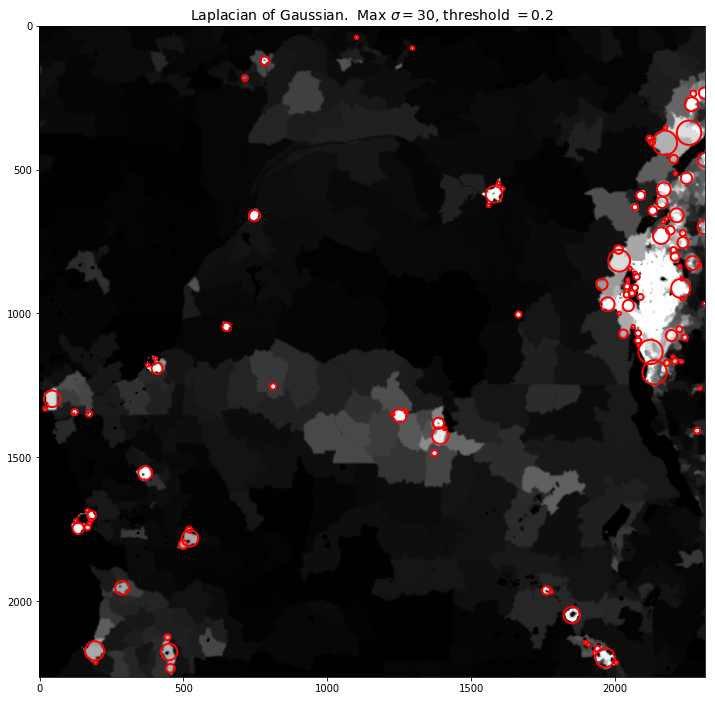

In [15]:
people_no_lights = detect_blobs(GPW_minus_BM_stats['mini_raster_array'], color='red', cmap='gray',
                               threshold=0.2)

In [16]:
print len(people_no_lights), "people-no-lights blobs found"

118 people-no-lights blobs found


# Lights no People

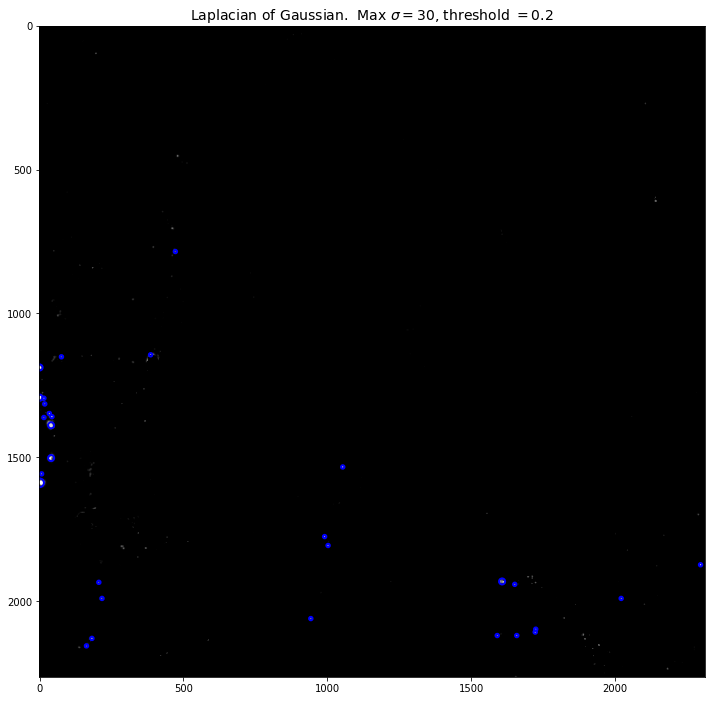

In [17]:
lights_no_people = detect_blobs(BM_minus_GPW_stats['mini_raster_array'], color='blue',cmap='gray',
                               threshold=0.2)

In [18]:
print len(lights_no_people), "lights-no-people blobs found"

30 lights-no-people blobs found


# Reverse Geocode Blob Centroids

In [21]:
def reverse_geocode(points):
    geolocator = Nominatim()
    
    lats = [i[0] for i in points]
    lons = [i[1] for i in points]
    
    df = pd.DataFrame()
    df['latitude'] = lats
    df['longitude'] = lons
    df['coordinates'] = zip(df.latitude, df.longitude)
    
    geography = []
    for i in tqdm(df.index):
        coords = df.loc[i]['coordinates']
        location = geolocator.reverse(coords)
        geodata = location.raw
        geography.append(geodata)
    df['geography'] = geography
    
    return df

In [22]:
people_no_lights_df = reverse_geocode(people_no_lights)


 16%|█▌        | 19/118 [00:08<00:41,  2.37it/s]
Exception in thread Thread-6:
Traceback (most recent call last):
  File "/anaconda/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/anaconda/lib/python2.7/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/anaconda/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


100%|██████████| 118/118 [00:48<00:00,  2.43it/s]


In [24]:
lights_no_people_df = reverse_geocode(lights_no_people)

100%|██████████| 30/30 [00:13<00:00,  2.17it/s]


In [25]:
def parse_geography(df):
    countries = [df['geography'][i]['address']['country'] for i in df.index]
    try:
        states = [df['geography'][i]['address']['state'] for i in df.index]
    except:
        states = None
    boundingboxes = [df['geography'][i]['boundingbox'] for i in df.index]
    display_names = [df['geography'][i]['display_name'] for i in df.index]
    df['country'] = countries
    df['state'] = states
    df['display_name'] = display_names
    df['bbox'] = boundingboxes
    del df['geography']
    return df

In [26]:
people_no_lights_df = parse_geography(people_no_lights_df)

In [27]:
lights_no_people_df = parse_geography(lights_no_people_df)

View the data.

In [28]:
people_no_lights_df.head()

,latitude,longitude,coordinates,country,state,display_name,bbox
0,-13.220833,15.829167,"(-13.2208333333, 15.8291666667)",Angola,Huambo,"Gandavira, Huambo, Angola","[-13.2750132, -13.1673264, 15.7171523, 15.8488..."
1,-13.054167,28.737500,"(-13.0541666667, 28.7375)",Zambia,Copperbelt Province,"Ndola, Copperbelt Province, Zambia","[-13.091543, -13.0217966, 28.7370451, 28.7472375]"
2,-13.054167,13.662500,"(-13.0541666667, 13.6625)",Angola,Benguela,"Catengue, Benguela, Angola","[-13.1119081, -12.9519081, 13.6594333, 13.8194..."
3,-12.912500,28.420833,"(-12.9125, 28.4208333333)",Zambia,Copperbelt Province,"Ndola, Copperbelt Province, Zambia","[-12.9352064, -12.9212038, 28.4231922, 28.4431..."
4,-12.770833,28.120833,"(-12.7708333333, 28.1208333333)",Zambia,Copperbelt Province,"Mindolo North, Kitwe, Copperbelt Province, Zambia","[-12.8246414, -12.7446414, 28.1393351, 28.2193..."


In [29]:
lights_no_people_df.head()

,latitude,longitude,coordinates,country,state,display_name,bbox
0,-12.570833,13.395833,"(-12.5708333333, 13.3958333333)",Angola,Benguela,"Bairro da Salina, Benguela, 666, Angola","[-12.5733187, -12.5722404, 13.3994416, 13.4002..."
1,-12.354167,13.554167,"(-12.3541666667, 13.5541666667)",Angola,Benguela,"Rua 1º de Dezembro, Vinte-Oito, Lobito, Bengue...","[-12.3540459, -12.3535628, 13.550174, 13.5505418]"
2,-12.270833,25.862500,"(-12.2708333333, 25.8625)",Zambia,North-Western Province,"North-Western Province, Zambia","[-12.2566754, -12.2410402, 25.8198206, 25.8664..."
3,-12.270833,25.295833,"(-12.2708333333, 25.2958333333)",Zambia,North-Western Province,"North-Western Province, Zambia","[-12.2803478, -12.2766366, 25.2942498, 25.2954..."
4,-12.170833,26.395833,"(-12.1708333333, 26.3958333333)",Zambia,North-Western Province,"Solwezi, North-Western Province, Zambia","[-12.1771941, -11.9914699, 26.274349, 26.3947413]"


Save blob centroids to csv.

In [60]:
people_no_lights_df.to_csv("output/people_no_lights_{}.csv".format(place_name), encoding='utf-8')
lights_no_people_df.to_csv("output/lights_no_people_{}.csv".format(place_name), encoding='utf-8')